In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.impute import SimpleImputer
from numpy import isnan
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Data preparation

In [2]:
measurements = pd.read_csv("measurements.csv", sep='\t')

In [3]:
measurements.head()

,latitude,O3,CO,PM10,CH4,PAHs,CFCs,warning,TEMP,PM2.5,longitude,PRES,H2CO,NOx,SO2,C2H3NO5,Pb,NH3
0,18.03496,5.39719,8.13706,8.23677,5.30518,5.68332,56.58951,0.0,15.12351,6.63473,-66.84990,1123.73089,53.77575,10.58553,9.32624,6.85321,98.41394,10.04983
1,30.24706,NaN,7.02685,8.34285,7.10340,6.33413,42.38396,1.0,21.54978,5.99609,115.04814,1093.26694,34.42106,7.44386,9.24628,6.71120,60.85026,6.53207
2,25.92127,8.94125,6.92314,8.40217,6.78511,9.72012,46.00224,1.0,8.52787,5.74025,86.79271,1193.54568,59.72648,7.66132,10.00849,6.90308,63.87881,10.92266
3,42.28639,4.65891,6.58650,8.00340,8.86422,9.61295,48.09666,1.0,14.71245,7.22868,18.84000,1058.29939,44.58693,7.67040,11.89142,6.63155,51.45561,6.18102
4,42.93369,5.63121,7.39188,8.25518,5.28743,7.82735,50.22963,1.0,14.62910,7.85712,-72.27814,1120.46113,52.19057,7.11043,7.38777,7.11360,65.86558,6.44605


In [4]:
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class DropDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_new = X.drop_duplicates()
        return X_new

class NullDeletion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_new = X.dropna()
        return X_new
    
class OutliersDeletion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def identify_outliers(self, a):
        self.lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
        self.upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
        return a[(a > self.upper) | (a < self.lower)]

    def transform(self, X, y=None):
        X_new = X.copy()
        sum_outliers = 0
        for column in X_new:
            if column != 'latitude' and column != 'longitude':
                indentified_outliers = self.identify_outliers(X_new[column]).index
                sum_outliers += len(indentified_outliers)
                X_new = X_new.drop(indentified_outliers)
        return X_new

First of all, lets clean data including warning feature

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_cleaning_pipeline = Pipeline(steps=[
    ('duplicates', DropDuplicates()),
    ('null', NullDeletion()),
    ('outliers', OutliersDeletion())
])

cleaned_data = data_cleaning_pipeline.fit_transform(measurements)

Now, lets transform data except warning feature. If we would transform also warning feature, the 0 and 1 values would be changed, but we do not want it. This is why the pipeline is divided into two parts: cleaning and transformation.

In [6]:
features = cleaned_data.columns.difference(['warning'])
warning_values = cleaned_data.warning
data_without_warning = cleaned_data.drop('warning', axis=1)

data_frame_without_warning = pd.DataFrame(data_without_warning, columns = features)

In [7]:
data_transform_pipeline = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('scale', StandardScaler())
])

preprocessed_data = data_transform_pipeline.fit_transform(data_frame_without_warning)

Return warning feature to the dataframe.

In [8]:
preprocessed_data_frame = pd.DataFrame(preprocessed_data, columns = list(features))
preprocessed_data_frame['warning'] = list(warning_values)
preprocessed_data_frame.head()

,C2H3NO5,CFCs,CH4,CO,H2CO,NH3,NOx,O3,PAHs,PM10,PM2.5,PRES,Pb,SO2,TEMP,latitude,longitude,warning
0,0.689160,0.019807,-0.119682,-0.921140,1.114979,1.571565,-0.173946,0.602951,1.306870,0.864436,-0.934342,1.568176,0.683874,0.768117,-0.643077,-0.294081,1.107429,1.0
1,0.603276,0.196576,1.103049,-1.270661,-0.171387,-0.843153,-0.164556,-1.607911,1.248232,0.341277,-0.148364,-1.538239,-0.336765,1.980889,-0.013129,0.593812,0.122010,1.0
2,0.753221,0.376144,-1.057425,-0.437945,0.477517,-0.694194,-0.745097,-1.123330,0.271246,0.667587,0.180629,-0.079656,0.846538,-0.773594,-0.021563,0.630267,-1.080965,1.0
3,0.412863,1.182111,-1.068694,1.229683,-0.420568,1.809673,0.306958,1.512946,0.756567,0.691109,-0.915044,1.454373,-1.785459,0.326368,0.822144,0.128187,0.546060,1.0
4,-1.250749,0.859238,1.431334,-0.251354,2.360813,-0.752104,2.228673,1.013269,1.074558,-0.967044,0.156987,-0.713733,-0.103224,0.836410,-0.176831,-1.250977,-0.219990,0.0


Let's check the correlation map to ensure that all previous steps are correct.

<AxesSubplot: >

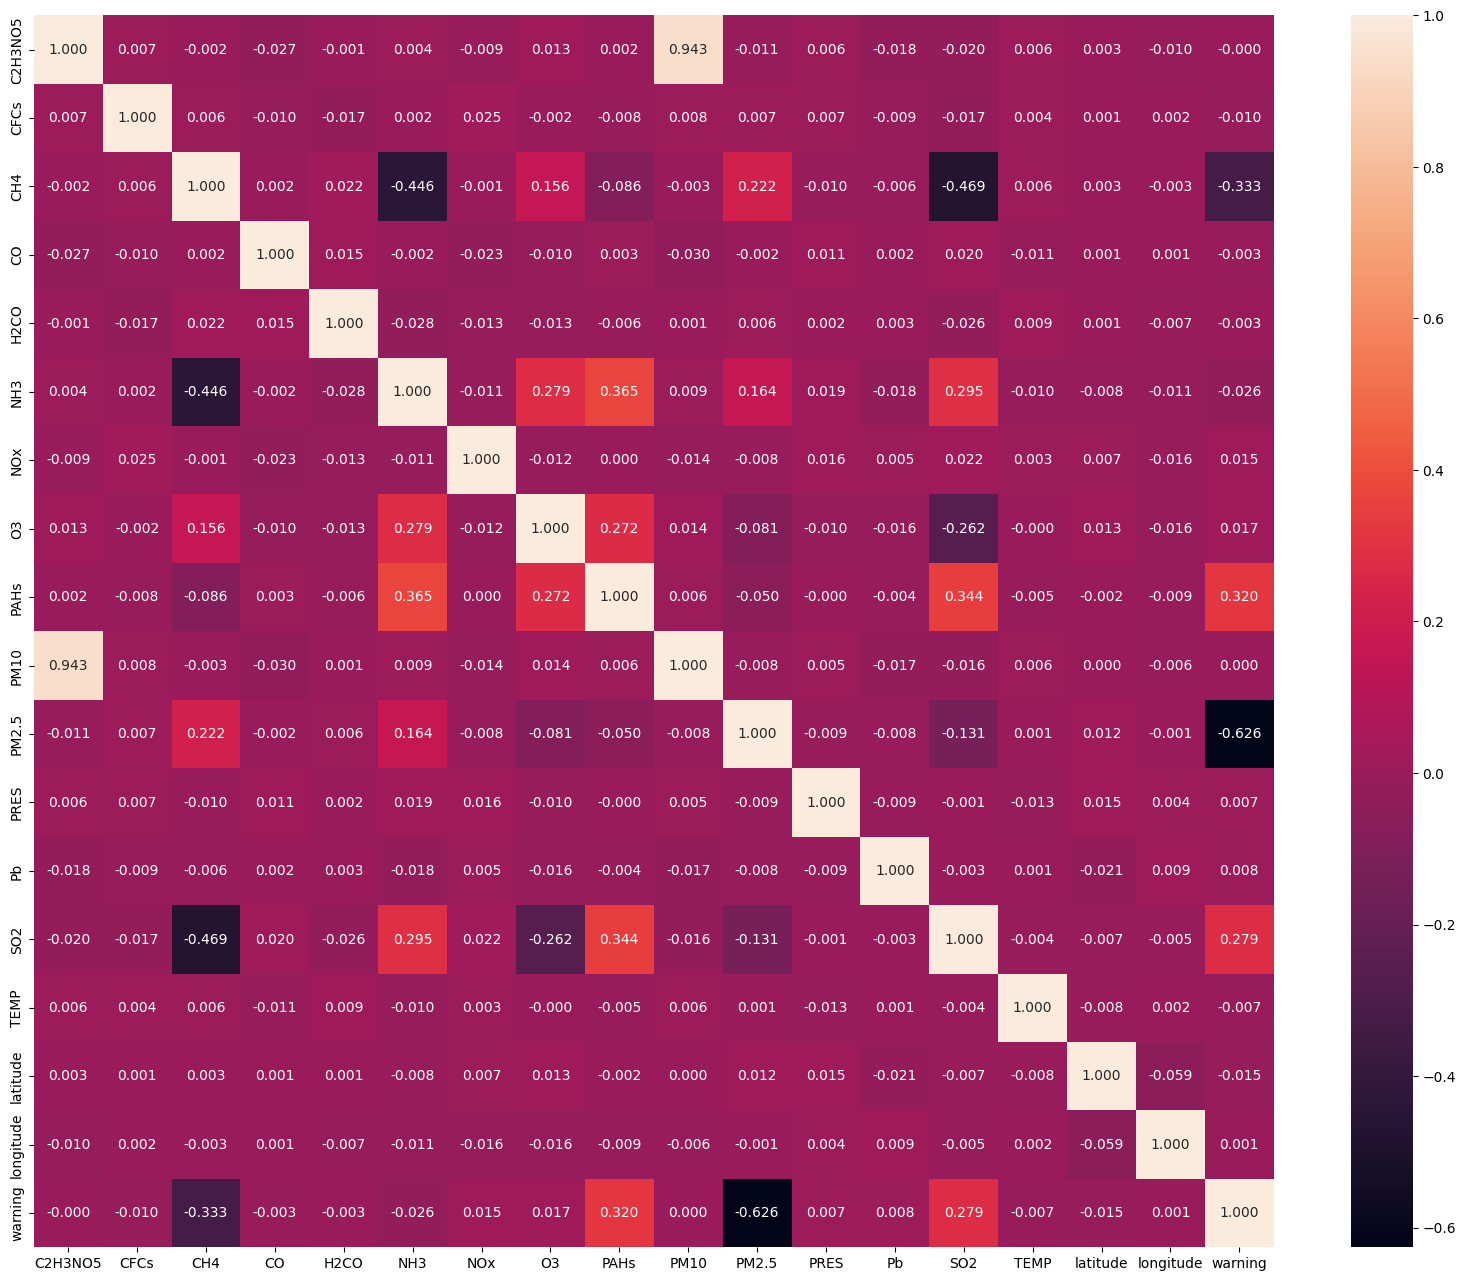

In [9]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(preprocessed_data_frame.corr(), ax=ax, annot=True, fmt=".3f")

### Lets select features from the previous phase

In [10]:
selected_features = preprocessed_data_frame[['CH4', 'PAHs', 'PM2.5', 'SO2', 'warning']]
selected_features.head()

,CH4,PAHs,PM2.5,SO2,warning
0,-0.119682,1.306870,-0.934342,0.768117,1.0
1,1.103049,1.248232,-0.148364,1.980889,1.0
2,-1.057425,0.271246,0.180629,-0.773594,1.0
3,-1.068694,0.756567,-0.915044,0.326368,1.0
4,1.431334,1.074558,0.156987,0.836410,0.0


### Split dataset into training and test set 

In [11]:
from sklearn.model_selection import train_test_split

features = selected_features.columns.difference(['warning'])
X = selected_features.drop('warning', axis=1)
Y = selected_features.warning

X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=0)
# X_train = pd.DataFrame(X_train, columns = features)
# X_train.head()

# Jednoduchý klasifikátor na základe závislosti v dátach (OneRule algorithm)

In [12]:
# Auxiliary function to calculate accuracy
# Based on type of correlation of chosen feature and warning, there are two ways to count accuracy.

"""
If correlation is positive, left side of warning array has to contain only 0 and the right side has to contain only 1 to
consider accuracy as 100%. In case of negative corellation, the left side has to contain only 1 and right one - 0 
"""

def calc_accuracy(left_side_count, right_side_count, correlation):
    if correlation == 'positive':
        return (left_side_count[0] + right_side_count[1]) / (sum(left_side_count) + sum(right_side_count))
    elif correlation == 'negative':
        return (left_side_count[1] + right_side_count[0]) / (sum(left_side_count) + sum(right_side_count))

In [13]:
# argument 'correlation' represents correlation between warning and selected feature

"""
algorithm moves pivot one by one in sorted by selected feature dataframe and 
calculates accuracy for the left and right side. Pivot value providing the best total accuracy is then returned.
"""

def oneR_calc_rule(dataframe, feature, correlation):
    sorted_data_frame = dataframe.sort_values(by=[feature])

    count_zero = sorted_data_frame['warning'].value_counts()[0]
    count_one = sorted_data_frame['warning'].value_counts()[1]

    right_side_count = [count_zero, count_one]
    left_side_count = [0, 0]

    best_accuracy = 0
    best_accuracy_feature_value = 0

    sorted_data_frame = sorted_data_frame.reset_index(drop=True)

    for i in range(len(sorted_data_frame[feature])):
        if sorted_data_frame['warning'][i] == 0:
            left_side_count[0] += 1
            right_side_count[0] -= 1
        elif sorted_data_frame['warning'][i] == 1:
            left_side_count[1] += 1
            right_side_count[1] -= 1

        cur_accuracy = calc_accuracy(left_side_count, right_side_count, correlation)

        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_accuracy_feature_value = sorted_data_frame[feature][i]

#         print(cur_accuracy)
    
    print(f"Decision (pivot) value of the feature {feature}: {best_accuracy_feature_value}")
    print(f"Accuracy: {best_accuracy}")

    return best_accuracy_feature_value

#### Now lets find feature that provides the best accuracy

In [14]:
train_data_frame = pd.DataFrame(X_train, columns = features)
train_data_frame['warning'] = list(y_train)

PM25_pivot = oneR_calc_rule(train_data_frame, 'PM2.5', 'negative')
oneR_calc_rule(train_data_frame, 'CH4', 'negative')
oneR_calc_rule(train_data_frame, 'SO2', 'positive')
oneR_calc_rule(train_data_frame, 'PAHs', 'positive')

Decision (pivot) value of the feature PM2.5: 0.2589387901426046
Accuracy: 0.8097459823742872
Decision (pivot) value of the feature CH4: 0.7732026668529077
Accuracy: 0.6898652151373769
Decision (pivot) value of the feature SO2: -0.9735286741838541
Accuracy: 0.6819595645412131
Decision (pivot) value of the feature PAHs: -0.9040051516077
Accuracy: 0.6572058061171592


-0.9040051516077

As we can see from the results above, the best accuracy is provided by using PM2.5 feature for a rule.
So the rule is the following:

* **if PM2.5 <= 0.2589387901426046, then warning = 1**
* **if PM2.5 > 0.2589387901426046, then warning = 0**

### Accuracy, precision a recall


In [15]:
# argument 'correlation' represents correlation between warning and selected feature
# argument pivot is a feature value that is used to make predictions.
def oneR_predict(dataframe, feature, pivot, correlation):
    result = []
    if correlation == 'negative':
        for i in dataframe[feature]:
            if i <= pivot:
                result.append(1)
            else:
                result.append(0)
        
    elif correlation == 'positive':
        for i in dataframe[feature]:
            if i <= pivot:
                result.append(0)
            else:
                result.append(1)
    
    return result

In [16]:
predicted_values = oneR_predict(X_test, 'PM2.5', PM25_pivot, 'negative')

In [17]:
print(f"accuracy: {accuracy_score(y_test, predicted_values)}\n")

# precision for all labes at once
print(f"precision for all labes at once: {precision_score(y_test, predicted_values, average='micro')}")

# precision for every label independently
print(f"precision for every label independently: {precision_score(y_test, predicted_values, average=None)}\n")


print(f"recall for all labes at once: {recall_score(y_test, predicted_values, average='micro')}")
print(f"recall for every label independently: {recall_score(y_test, predicted_values, average=None)}")

accuracy: 0.8055987558320373

precision for all labes at once: 0.8055987558320373
precision for every label independently: [0.7457847  0.84542314]

recall for all labes at once: 0.8055987558320373
recall for every label independently: [0.76259947 0.83319149]


In [18]:
print(classification_report(y_test, predicted_values))

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       754
         1.0       0.85      0.83      0.84      1175

    accuracy                           0.81      1929
   macro avg       0.80      0.80      0.80      1929
weighted avg       0.81      0.81      0.81      1929



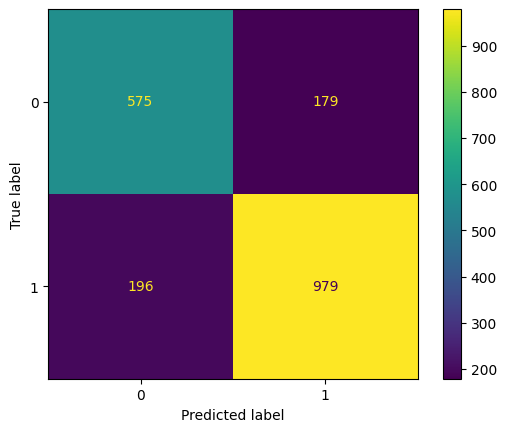

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted_values))
disp = disp.plot()

# Trénovanie a vyhodnotenie klasifikátorov strojového učenia

### Random forest

In [20]:
random_forest_model = RandomForestClassifier()
random_forest_model = random_forest_model.fit(X_train, y_train)
# tree.plot_tree(clf) 

y_predicted_random_forest = random_forest_model.predict(X_test)

print('Training accuracy: ', random_forest_model.score(X_train,y_train))
print('Test Accuracy: ', random_forest_model.score(X_test, y_test))

Training accuracy:  1.0
Test Accuracy:  0.9170554691550026


### Decision Tree (CART)

In [21]:
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model = decision_tree_model.fit(X_train, y_train)

y_predicted_decision_tree = decision_tree_model.predict(X_test)

print('Training accuracy: ', decision_tree_model.score(X_train, y_train))
print('Test Accuracy: ', decision_tree_model.score(X_test, y_test))
# tree.plot_tree(decision_tree_model) 

Training accuracy:  1.0
Test Accuracy:  0.873509590461379


### Visualization of trained rules

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

graph = Source(export_graphviz(decision_tree_model, 
                               out_file=None,
                               feature_names=X_train.columns,
                               class_names=['0', '1'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:100% !important;height:70% !important;}</style>"
HTML(style)

### Accuracy, precision a recall


#### Random forest

In [22]:
print(f"accuracy: {accuracy_score(y_test, y_predicted_random_forest)}\n")

# precision for all labes at once
print(f"precision for all labes at once: {precision_score(y_test, y_predicted_random_forest, average='micro')}")

# precision for every label independently
print(f"precision for every label independently: {precision_score(y_test, y_predicted_random_forest, average=None)}\n")


print(f"recall for all labes at once: {recall_score(y_test, y_predicted_random_forest, average='micro')}")
print(f"recall for every label independently: {recall_score(y_test, y_predicted_random_forest, average=None)}")

accuracy: 0.9170554691550026

precision for all labes at once: 0.9170554691550026
precision for every label independently: [0.91135734 0.92046396]

recall for all labes at once: 0.9170554691550026
recall for every label independently: [0.87267905 0.94553191]


In [23]:
print(classification_report(y_test, y_predicted_random_forest))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89       754
         1.0       0.92      0.95      0.93      1175

    accuracy                           0.92      1929
   macro avg       0.92      0.91      0.91      1929
weighted avg       0.92      0.92      0.92      1929



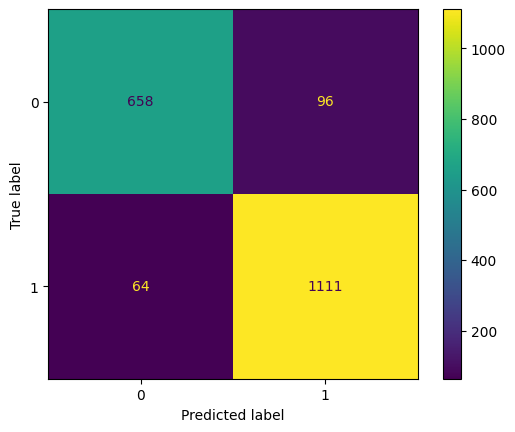

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted_random_forest))
disp = disp.plot()

#### Decision tree

In [25]:
print(f"accuracy: {accuracy_score(y_test, y_predicted_decision_tree)}\n")

# precision for all labes at once
print(f"precision for all labes at once: {precision_score(y_test, y_predicted_decision_tree, average='micro')}")

# precision for every label independently
print(f"precision for every label independently: {precision_score(y_test, y_predicted_decision_tree, average=None)}\n")


print(f"recall for all labes at once: {recall_score(y_test, y_predicted_decision_tree, average='micro')}")
print(f"recall for every label independently: {recall_score(y_test, y_predicted_decision_tree, average=None)}")

accuracy: 0.873509590461379

precision for all labes at once: 0.873509590461379
precision for every label independently: [0.83730159 0.89684569]

recall for all labes at once: 0.873509590461379
recall for every label independently: [0.83952255 0.89531915]


In [26]:
print(classification_report(y_test, y_predicted_decision_tree))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       754
         1.0       0.90      0.90      0.90      1175

    accuracy                           0.87      1929
   macro avg       0.87      0.87      0.87      1929
weighted avg       0.87      0.87      0.87      1929



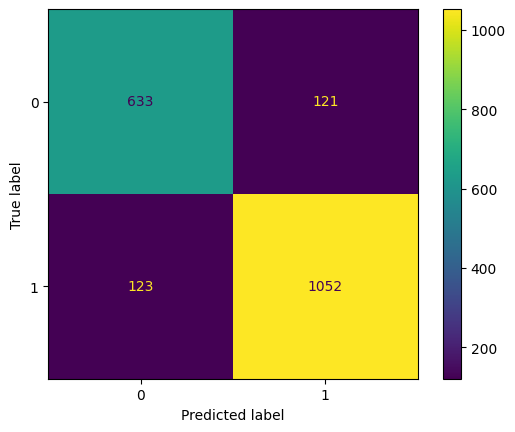

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted_decision_tree))
disp = disp.plot()

#### As can be seen from the results, random forest gives expectedly better results than one decision tree

### Random forest vs OneRule comparison vs Decision Tree (CART)

| Classifier           | Training accuracy | Test accuracy | Test precision | Test recall |
|----------------------|-------------------|---------------|-----------|--------|
| Random Forest        | 1                 | 0.92          | 0.92      | 0.92   |
| Decision Tree (CART) | 1                 | 0.87          | 0.87      | 0.87   |
| OneRule              | 0.81              | 0.80          | 0.80      | 0.80   |

Table represents results received from classifiers. As can be seen, the best results are provided by Random Forest algorithm (0.92 total accuracy on training dataset), in the middle is single Decision Tree (0.87 total accuracy on training dataset). And the simpliest algorithm OneRule gave 0.80 total accuracy on training dataset. Although OneRule algorithm has the worst results among reviewed methods, 80% accuracy is still relatively good result for such simple approach.

Talking about speed, the fastest is OneRule, then Decision Tree, and the slowest - Random Forest

# Optimalizácia alias hyperparameter tuning

Hyperparameters will help us to optimize our chosen algorithm even better. But to find the exact parameters we need a search algorith to find them. For this, we will use Randomized Search.

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from pprint import pprint
from scipy.stats import randint as sp_randint

model = RandomForestClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

clf = RandomizedSearchCV(model, 
                         param_dist,
                         random_state=0)

search = clf.fit(X_train, y_train)

print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)
# pprint(search.cv_results_)

RandomForestClassifier(criterion='entropy', max_features=1, min_samples_leaf=4,
                       min_samples_split=4)
0.9223708776725241
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 4}
5


As we can see, Randomized search found optimal values for parameters we gave him. These parameters mean:

- bootstrap: provides train/test indices to split data in train test sets while resampling the input n_bootstraps times: each time a new random split of the data is performed and then samples are drawn (with replacement) on each side of the split to build the training and test sets

- criterion: of the optimal estimate of the regularization parameter by computing a single regularization path (instead of several when using cross-validation):

- max_depth: the maximum depth of the tree

- max_features: maximum number of features seen during fit

- min_samples_leaf: the minimum number of samples required to be at a leaf node

- min_samples_split: the minimum number of samples required to split an internal node

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

In [29]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
    plt.figure(figsize=(12,6))
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
    X_axis = np.arange(len(labels))
    ax = plt.gca()
    plt.ylim(0.40000, 1)
    plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
    plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
    plt.title(plot_title, fontsize=30)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def cross_validation(model, _X, _y, _cv=5):
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
    return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean()
            }

In [31]:
from sklearn.model_selection import cross_validate

random_forest_model = RandomForestClassifier()
random_forest_result = cross_validation(random_forest_model, X, Y, 5)
print(random_forest_result)

{'Training Accuracy scores': array([0.9998704, 1.       , 1.       , 1.       , 0.9998704]), 'Mean Training Accuracy': 99.99481596682219, 'Training Precision scores': array([1.        , 1.        , 1.        , 1.        , 0.99978591]), 'Mean Training Precision': 0.9999571826161422, 'Training Recall scores': array([0.99978582, 1.        , 1.        , 1.        , 1.        ]), 'Mean Training Recall': 0.9999571642750054, 'Training F1 scores': array([0.9998929 , 1.        , 1.        , 1.        , 0.99989295]), 'Mean Training F1 Score': 0.9999571688597981, 'Validation Accuracy scores': array([0.9222395 , 0.9217211 , 0.92638673, 0.91912908, 0.91912908]), 'Mean Validation Accuracy': 92.17210990150339, 'Validation Precision scores': array([0.91721311, 0.92911392, 0.93916024, 0.92514718, 0.93094629]), 'Mean Validation Precision': 0.9283161505605179, 'Validation Recall scores': array([0.95804795, 0.94263699, 0.93916024, 0.94258783, 0.93573265]), 'Mean Validation Recall': 0.9436331302602387, 'Va

We will use 5 k-fold cross validation and test results in accuracy, recall and F1 score.

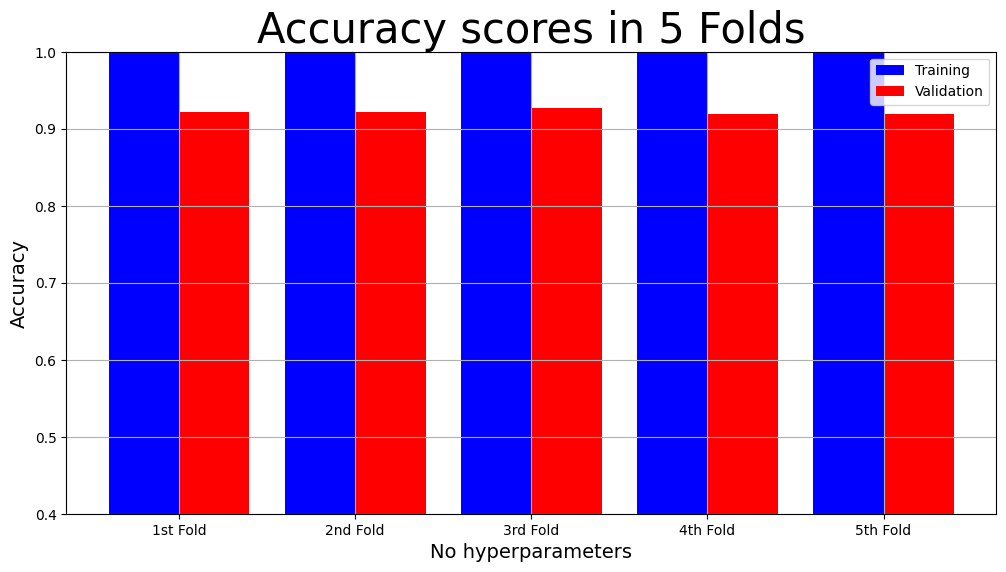

In [32]:
model_name = "No hyperparameters"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            random_forest_result["Training Accuracy scores"],
            random_forest_result["Validation Accuracy scores"])

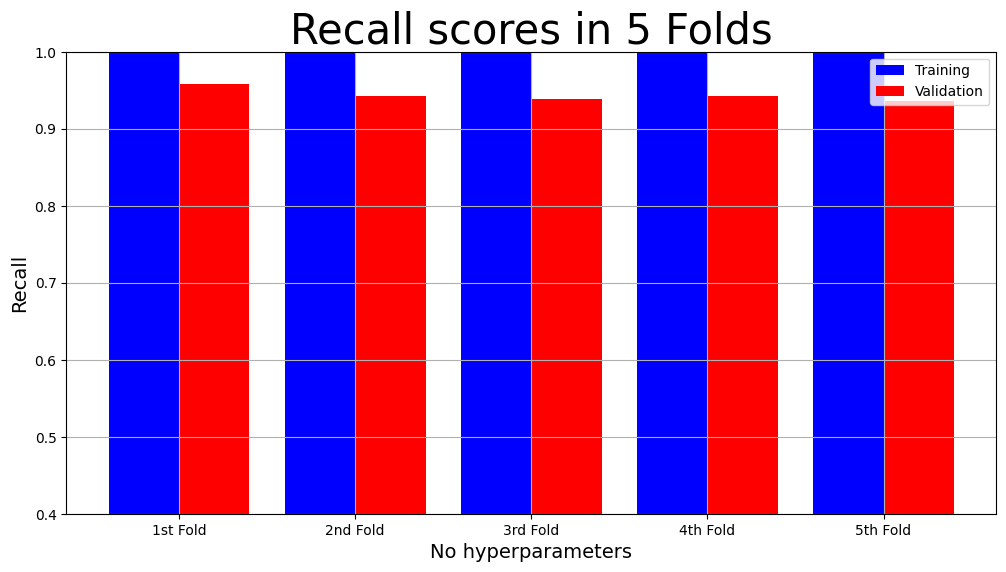

In [33]:
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            random_forest_result["Training Recall scores"],
            random_forest_result["Validation Recall scores"])

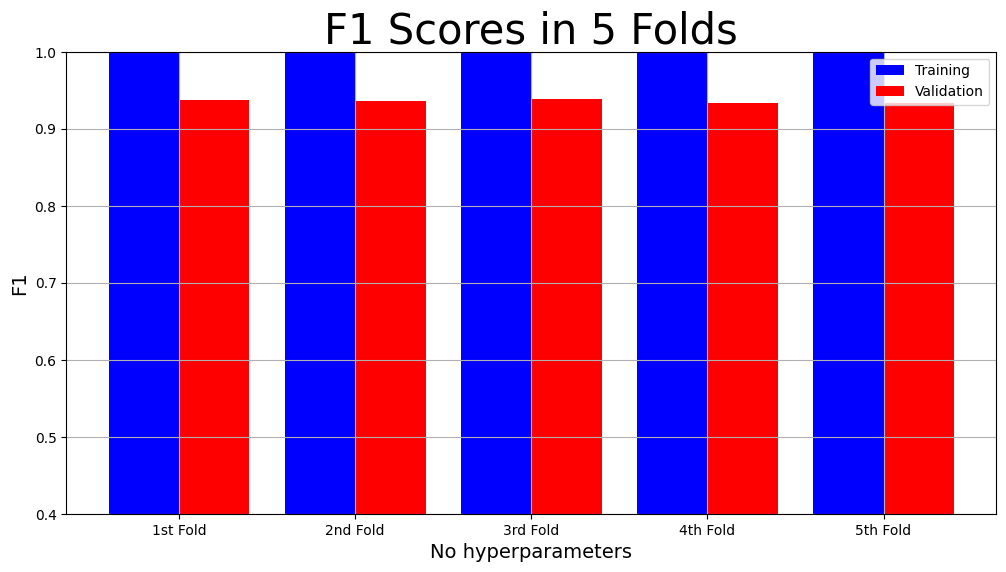

In [34]:
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            random_forest_result["Training F1 scores"],
            random_forest_result["Validation F1 scores"])

As we can see, if we don't use any hyperparematers, the performance on test data is ~8-10% worse than on training data. Now, let's see the results of using hyperparameters.

In [35]:
random_forest_model_2 = RandomForestClassifier(**(search.best_params_))
random_forest_result_2 = cross_validation(random_forest_model_2, X, Y, 5)
print(random_forest_result_2)

{'Training Accuracy scores': array([0.9530845 , 0.9528253 , 0.9528253 , 0.9529549 , 0.95463971]), 'Mean Training Accuracy': 95.32659409020218, 'Training Precision scores': array([0.95232094, 0.95135248, 0.94985374, 0.953273  , 0.95435423]), 'Mean Training Precision': 0.9522308778058164, 'Training Recall scores': array([0.97108589, 0.97172842, 0.97344754, 0.96980728, 0.97152034]), 'Mean Training Recall': 0.971517893546344, 'Training F1 scores': array([0.96161188, 0.96143251, 0.96150592, 0.96146906, 0.96286078]), 'Mean Training F1 Score': 0.9617760291024577, 'Validation Accuracy scores': array([0.9212027 , 0.92275791, 0.92327631, 0.92275791, 0.92483152]), 'Mean Validation Accuracy': 92.29652669777086, 'Validation Precision scores': array([0.91166937, 0.9270746 , 0.93435635, 0.92275748, 0.9323181 ]), 'Mean Validation Precision': 0.9256351801958939, 'Validation Recall scores': array([0.96318493, 0.94691781, 0.93916024, 0.95201371, 0.94430163]), 'Mean Validation Recall': 0.9491156636264394,

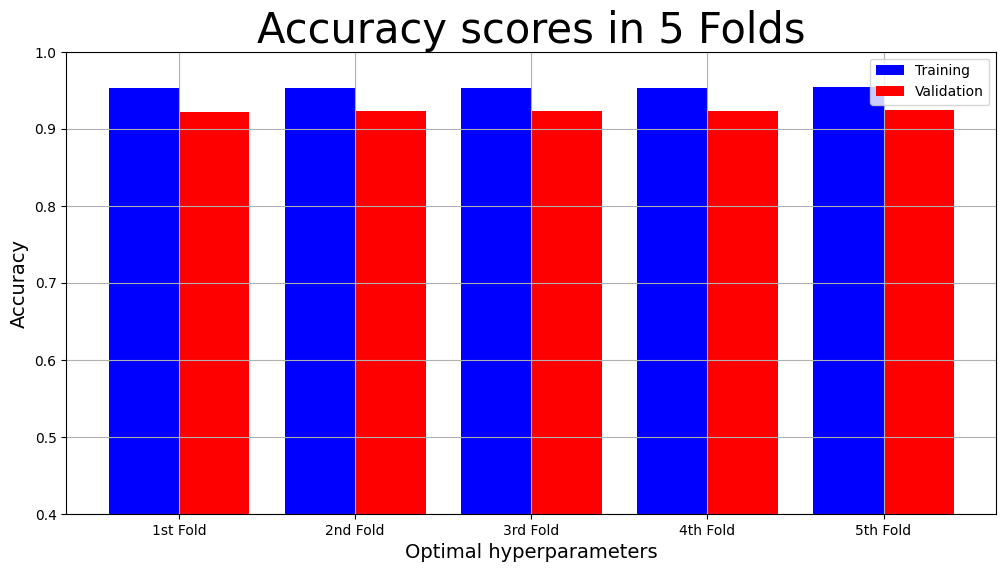

In [36]:
model_name = "Optimal hyperparameters"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            random_forest_result_2["Training Accuracy scores"],
            random_forest_result_2["Validation Accuracy scores"])

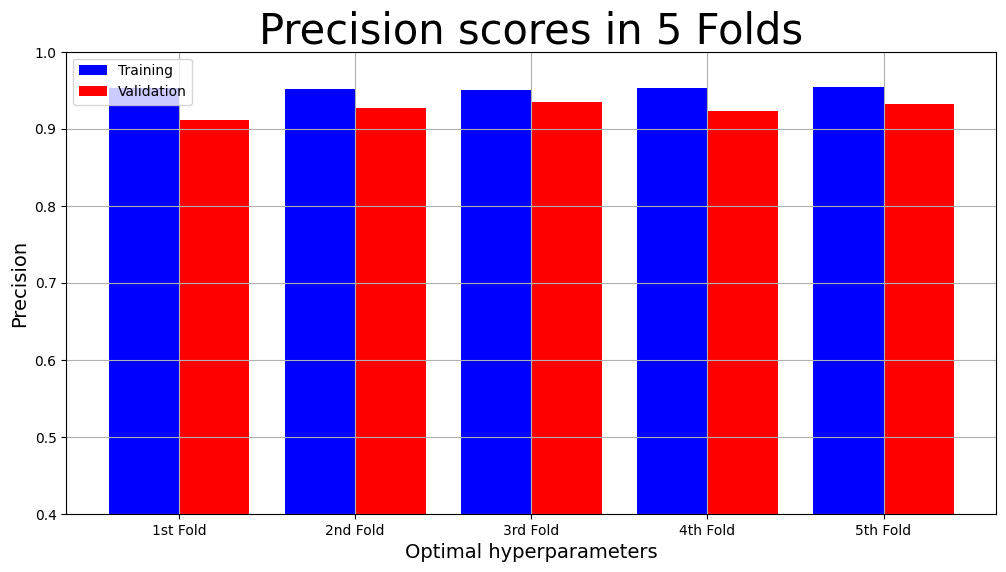

In [37]:
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            random_forest_result_2["Training Precision scores"],
            random_forest_result_2["Validation Precision scores"])

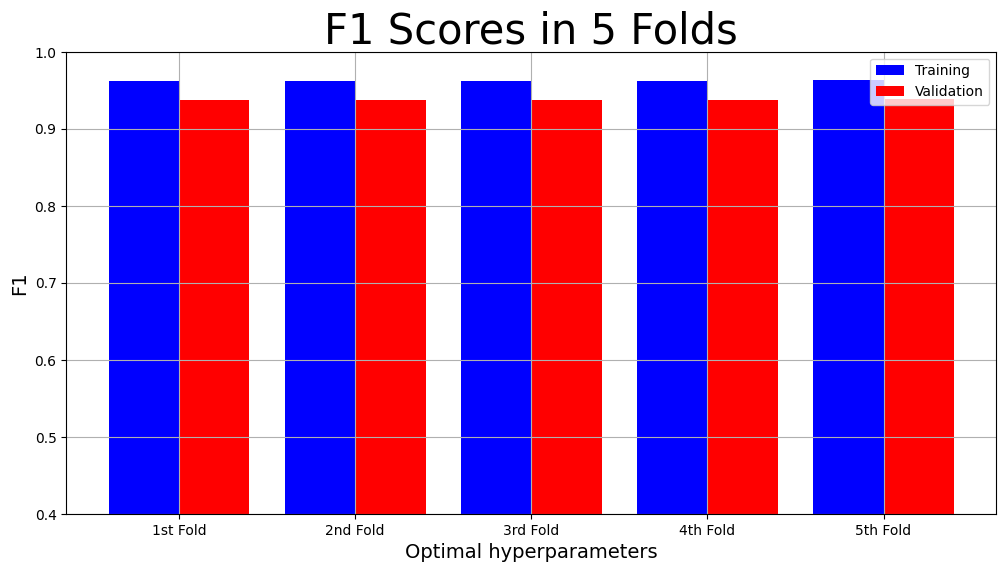

In [38]:
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            random_forest_result_2["Training F1 scores"],
            random_forest_result_2["Validation F1 scores"])

There we can see that although overall accuracy and performance was a little lower than without hyperparametes, the performance on training data and on set data is noticeably better compared to training data. This will lead our algorithm to perform better on previously unseen data.

# Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### 1) Stratégie riešenia chýbajúcich hodnôt a outlierov

To see the effectiveness to the accuracy of clearing outliers in dataset, we will create a copy of original dataset and perform all transformations except null detection and outlier detection.

In [39]:
import matplotlib.pyplot as plt

X_train_origin = X_train
y_train_origin = y_train
X_test_origin = X_test
y_test_origin = y_test

No clearing score:  0.9186106791083463
With clearing score:  0.9223708776725241


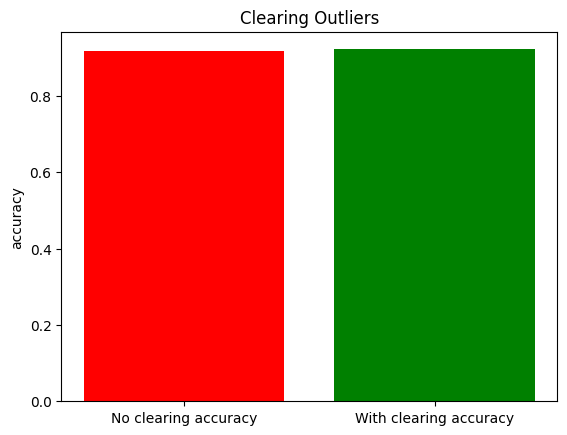

In [40]:
measurements = pd.read_csv("measurements.csv", sep='\t')

features = measurements.columns.difference(['warning'])
warning_values = measurements.warning
data_without_warning = measurements.drop('warning', axis=1)

data_frame_without_warning = pd.DataFrame(data_without_warning, columns = features)

preprocessed_data = data_transform_pipeline.fit_transform(data_frame_without_warning)

selected_features = preprocessed_data_frame[['CH4', 'PAHs', 'PM2.5', 'SO2', 'warning']]

features = selected_features.columns.difference(['warning'])
X = selected_features.drop('warning', axis=1)
Y = selected_features.warning
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=0)

random_forest_no_clearing = RandomForestClassifier()
random_forest_no_clearing = random_forest_no_clearing.fit(X_train, y_train)
y_predicted_random_forest_no_clearing = random_forest_no_clearing.predict(X_test)
print("No clearing score: ", random_forest_no_clearing.score(X_test, y_test))
print("With clearing score: ", search.best_score_)

left = [1, 2]
  
height = [random_forest_no_clearing.score(X_test, y_test), search.best_score_]
  
tick_label = ['No clearing accuracy', 'With clearing accuracy']
  
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

plt.ylabel('accuracy')
plt.title('Clearing Outliers')
plt.show()

### 2) Scaling resp. transformer či zlepší accuracy klasifikácie

To see the effectiveness to the accuracy of using transformers in dataset, we will create a copy of original dataset and perform all transformations except transofmers.

For the data to be usable in machine learning, we need to use a scaling technique in both variants.

No transform score:  0.9170554691550026
With transform score:  0.9223708776725241


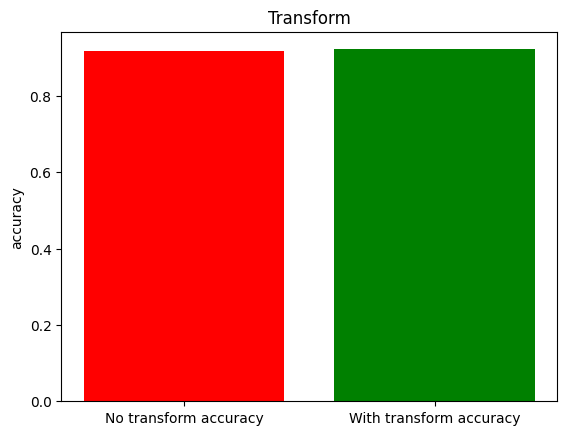

In [41]:
measurements = pd.read_csv("measurements.csv", sep='\t')

cleaned_data = data_cleaning_pipeline.fit_transform(measurements)

features = cleaned_data.columns.difference(['warning'])
warning_values = cleaned_data.warning
data_without_warning = cleaned_data.drop('warning', axis=1)

scaler = StandardScaler()
preprocessed_data = scaler.fit_transform(data_frame_without_warning)
selected_features = preprocessed_data_frame[['CH4', 'PAHs', 'PM2.5', 'SO2', 'warning']]

features = selected_features.columns.difference(['warning'])
X = selected_features.drop('warning', axis=1)
Y = selected_features.warning

X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=0)

random_forest_no_transform = RandomForestClassifier()
random_forest_no_transform = random_forest_no_transform.fit(X_train, y_train)
y_predicted_random_forest_no_transform = random_forest_no_transform.predict(X_test)
print("No transform score: ", random_forest_no_transform.score(X_test, y_test))
print("With transform score: ", search.best_score_)

left = [1, 2]
  
height = [random_forest_no_transform.score(X_test, y_test), search.best_score_]
  
tick_label = ['No transform accuracy', 'With transform accuracy']
  
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

plt.ylabel('accuracy')
plt.title('Transform')
plt.show()

### 3.1) Výber atribútov


To see the effectiveness to the accuracy of using our chosen attributes in dataset, we will create a copy of original dataset and perform all transformations on completely different attributes.

wrong attributes:  0.7729393468118196
correct attributes:  0.9223708776725241


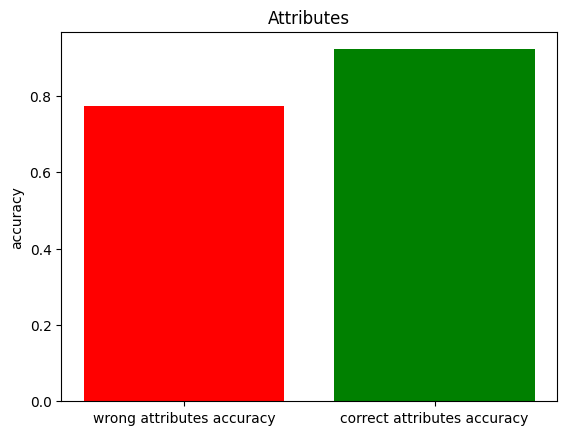

In [42]:
measurements = pd.read_csv("measurements.csv", sep='\t')

cleaned_data = data_cleaning_pipeline.fit_transform(measurements)

features = cleaned_data.columns.difference(['warning'])
warning_values = cleaned_data.warning
data_without_warning = cleaned_data.drop('warning', axis=1)

preprocessed_data = data_transform_pipeline.fit_transform(data_frame_without_warning)
selected_features = preprocessed_data_frame[['NOx', 'NH3', 'CO', 'O3', 'warning']]

features = selected_features.columns.difference(['warning'])
X = selected_features.drop('warning', axis=1)
Y = selected_features.warning

X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=0)

random_forest_wrong_attributes = RandomForestClassifier()
random_forest_wrong_attributes = random_forest_wrong_attributes.fit(X_train, y_train)
y_predicted_random_forest_wrong_attributes = random_forest_wrong_attributes.predict(X_test)

print("wrong attributes: ", random_forest_wrong_attributes.score(X_test, y_test))
print("correct attributes: ", search.best_score_)

left = [1, 2]
  
height = [random_forest_wrong_attributes.score(X_test, y_test), search.best_score_]
  
tick_label = ['wrong attributes accuracy', 'correct attributes accuracy']
  
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

plt.ylabel('accuracy')
plt.title('Attributes')
plt.show()

### 3.2) výber algoritmov strojového učenia

To see the effectiveness to the accuracy of using different algorithms in dataset, we will compare our chosen random forest algorithm to a standart desicion tree (CART) algorithm.

decision tree score:  0.8755832037325039
random forest score:  0.9180922757905651


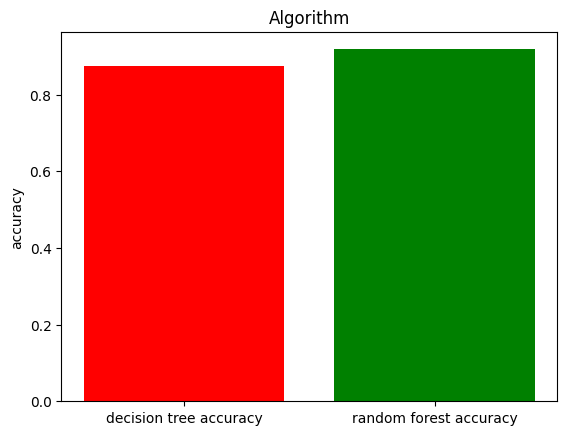

In [43]:
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model = decision_tree_model.fit(X_train_origin, y_train_origin)
y_predicted_decision_tree = decision_tree_model.predict(X_test_origin)

random_forest_model = RandomForestClassifier()
random_forest = random_forest_model.fit(X_train_origin, y_train_origin)
y_predicted_random_forest = random_forest.predict(X_test_origin)

print("decision tree score: ", decision_tree_model.score(X_test_origin, y_test_origin))
print("random forest score: ", random_forest.score(X_test_origin, y_test_origin))

left = [1, 2]
  
height = [decision_tree_model.score(X_test_origin, y_test_origin), random_forest.score(X_test_origin, y_test_origin)]
  
tick_label = ['decision tree accuracy', 'random forest accuracy']
  
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

plt.ylabel('accuracy')
plt.title('Algorithm')
plt.show()

### 4) Hyperparameter tuning resp. ensemble learning

To see the effectiveness to the accuracy of using hyperparameters, we will compare an algoritm with no tuned hyperparameters to a algorithm with optimal hyperparameters using random search.

no hyperparameters 0.9206842923794712
optimal hyperparameters 0.9180922757905651


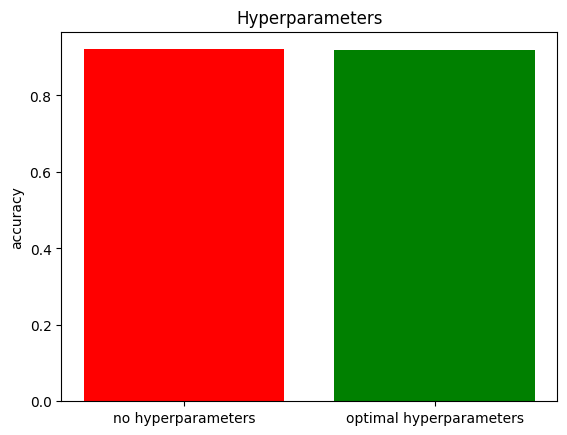

In [44]:
random_forest_model_1 = RandomForestClassifier()
random_forest_1 = random_forest_model_1.fit(X_train_origin, y_train_origin)
y_predicted_random_forest_1 = random_forest_1.predict(X_test_origin)

random_forest_model_2 = RandomForestClassifier(**(search.best_params_))
random_forest_2 = random_forest_model_2.fit(X_train_origin, y_train_origin)
y_predicted_random_forest_2 = random_forest_2.predict(X_test_origin)

print("no hyperparameters", random_forest_1.score(X_test_origin, y_test_origin))
print("optimal hyperparameters", random_forest_2.score(X_test_origin, y_test_origin))

left = [1, 2]
  
height = [random_forest_model_1.score(X_test_origin, y_test_origin), random_forest_2.score(X_test_origin, y_test_origin)]
  
tick_label = ['no hyperparameters', 'optimal hyperparameters']
  
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

plt.ylabel('accuracy')
plt.title('Hyperparameters')
plt.show()

## Result:

As was seen on graphs, every part of our chosen stratedy, that includes methods of null detection and outliers detection, transformers and scalings, chosen attributes, algorithm methods and hyperparemeter tuning, this methods bring an increase to result of prediciton and its accuracy. It all shows that our project is adjusted to perform better, even on unseen data.